Attempt number two at creating a custom neuron class. Decided to base it off of the Izhikevich implementation by Nengo because the dV formula in step_math function looked to be a good fit for the custom LIF equation. Also, at this time did not fully understand Nengo's LIF implementation as they had no reference to where they got the equations. Was successful but difficult to modify so many things to make it LIF.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.params import Parameter, NumberParam
from nengo.neurons import settled_firingrate


class CustomLIF(nengo.neurons.NeuronType):  # Neuron types must subclass `nengo.Neurons`
    """A custum LIF neuron model."""
    
    probeable = ("spikes", "voltage", "recovery")

    tau_recovery = NumberParam("tau_recovery", low=0, low_open=True)
    coupling = NumberParam("coupling", low=0)
    reset_voltage = NumberParam("reset_voltage")
    reset_recovery = NumberParam("reset_recovery")
    tau_v = NumberParam("tau_v")

    def __init__(
        self, tau_recovery=0.02, coupling=0.2, reset_voltage=-65.0, reset_recovery=8.0, tau_v=2 
    ):
        super().__init__()
        self.tau_recovery = tau_recovery
        self.coupling = coupling
        self.reset_voltage = reset_voltage
        self.reset_recovery = reset_recovery
        self.tau_v = tau_v

    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = np.zeros_like(J)
        recovery = np.zeros_like(J)
        return settled_firingrate(
            self.step_math, J, [voltage, recovery], settle_time=0.001, sim_time=1.0
        )
    
    def step_math(self, dt, J, spiked, voltage, recovery):
        """Implement the differential equation for LIF."""
        # Numerical instability occurs for very low inputs.
        # We'll clip them be greater than some value that was chosen by
        # looking at the simulations for many parameter sets.
        # A more principled minimum value would be better.
        J = np.maximum(-30.0, J)
        
        dV = (0.08 * 1/self.tau_v * voltage ** 2 + 5 * voltage + 140 - recovery + J) * 1000
        voltage[:] += dV * dt

        # We check for spikes and reset the voltage here rather than after,
        # which differs from the original implementation by Izhikevich.
        # However, calculating recovery for voltage values greater than
        # threshold can cause the system to blow up, which we want
        # to avoid at all costs.
        spiked[:] = (voltage >= 30) / dt
        voltage[spiked > 0] = self.reset_voltage

        dU = (self.tau_recovery * (self.coupling * voltage - recovery)) * 1000
        recovery[:] += dU * dt
        recovery[spiked > 0] = recovery[spiked > 0] + self.reset_recovery

In [2]:
from nengo.builder.operator import Operator

class SimCustomLIF(Operator):
    """Set a neuron model output for the given input current.

    Implements ``neurons.step_math(dt, J, output, *states)``.

    Parameters
    ----------
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    J : Signal
        The input current.
    output : Signal
        The neuron output signal that will be set.
    states : list, optional
        A list of additional neuron state signals set by ``step_math``.
    tag : str, optional
        A label associated with the operator, for debugging purposes.

    Attributes
    ----------
    J : Signal
        The input current.
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    output : Signal
        The neuron output signal that will be set.
    states : list
        A list of additional neuron state signals set by ``step_math``.
    tag : str or None
        A label associated with the operator, for debugging purposes.

    Notes
    -----
    1. sets ``[output] + states``
    2. incs ``[]``
    3. reads ``[J]``
    4. updates ``[]``
    """

    def __init__(self, neurons, J, output, states=None, tag=None):
        super().__init__(tag=tag)
        self.neurons = neurons

        self.sets = [output] + ([] if states is None else states)
        self.incs = []
        self.reads = [J]
        self.updates = []

    @property
    def J(self):
        return self.reads[0]

    @property
    def output(self):
        return self.sets[0]

    @property
    def states(self):
        return self.sets[1:]

    def _descstr(self):
        return "%s, %s, %s" % (self.neurons, self.J, self.output)

    def make_step(self, signals, dt, rng):
        J = signals[self.J]
        output = signals[self.output]
        states = [signals[state] for state in self.states]

        def step_simcustomlif():
            self.neurons.step_math(dt, J, output, *states)

        return step_simcustomlif

In [3]:
from nengo.builder import Builder
from nengo.builder.operator import Copy
from nengo.builder.signal import Signal
from nengo.rc import rc


@Builder.register(CustomLIF)
def build_customlif(model, neuron_type, neurons):
    """Builds an `.CustomLIF` object into a model.

    In addition to adding a `.SimCustomLIF` operator, this build function sets up
    signals to track the voltage and recovery terms for each neuron.

    Parameters
    ----------
    model : Model
        The model to build into.
    neuron_type : CustomLIF
        Neuron type to build.
    neuron : Neurons
        The neuron population object corresponding to the neuron type.

    Notes
    -----
    Does not modify ``model.params[]`` and can therefore be called
    more than once with the same `.CustomLIF` instance.
    """

    model.sig[neurons]["voltage"] = Signal(
        np.ones(neurons.size_in, dtype=rc.float_dtype) * neuron_type.reset_voltage,
        name="%s.voltage" % neurons,
    )
    model.sig[neurons]["recovery"] = Signal(
        np.ones(neurons.size_in, dtype=rc.float_dtype)
        * neuron_type.reset_voltage
        * neuron_type.coupling,
        name="%s.recovery" % neurons,
    )
    model.add_op(
        SimCustomLIF(
            neurons=neuron_type,
            J=model.sig[neurons]["in"],
            output=model.sig[neurons]["out"],
            states=[model.sig[neurons]["voltage"], model.sig[neurons]["recovery"]],
        )
    )

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

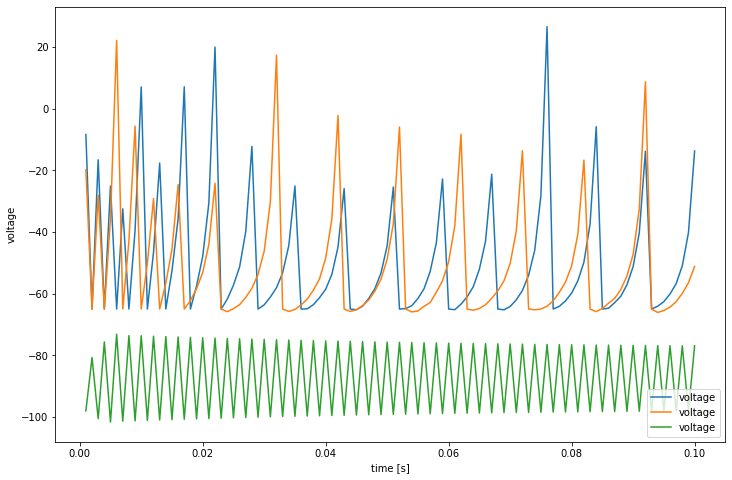

In [4]:

model = nengo.Network(label='2D Representation', seed=10)
process = nengo.processes.WhiteNoise(
    dist=nengo.dists.Gaussian(0, .01), seed=1)
with model:
    a = nengo.Ensemble(3, dimensions=2, noise=process, neuron_type=CustomLIF())
#     sin = nengo.Node(output=np.sin)
#     cos = nengo.Node(output=np.cos)
#     nengo.Connection(sin, a[0])
#     nengo.Connection(cos, a[1])
#     sin_probe = nengo.Probe(sin, 'output')
#     cos_probe = nengo.Probe(cos, 'output')
#     neurons_probe = nengo.Probe(a, 'decoded_output', synapse=0.01)
    voltage_probe = nengo.Probe(a.neurons, 'voltage')
with nengo.Simulator(model) as sim:
    sim.run(.1)
    
plt.figure(figsize=(12, 8))

plt.plot(sim.trange(), sim.data[voltage_probe], label="voltage")

plt.xlabel('time [s]')
plt.ylabel('voltage')
plt.legend(loc=4);